In [1]:
# StarGAN 소스코드 불러오기
!git clone https://github.com/yunjey/StarGAN

Cloning into 'StarGAN'...
remote: Enumerating objects: 162, done.
remote: Total 162 (delta 0), reused 0 (delta 0), pack-reused 162
Receiving objects: 100% (162/162), 13.76 MiB | 30.23 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [2]:
# StarGAN 저장소로 들어가기
%cd StarGAN

/content/StarGAN


In [3]:
# CelebA 데이터 셋(256 x 256 크기)을 이용해 사전 학습된 모델 다운로드
!mkdir -p ./stargan_celeba_256/models/
!wget -N https://www.dropbox.com/s/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip?dl=0 -O ./stargan_celeba_256/models/celeba-256x256-5attrs.zip
!unzip ./stargan_celeba_256/models/celeba-256x256-5attrs.zip -d ./stargan_celeba_256/models/
!rm ./stargan_celeba_256/models/celeba-256x256-5attrs.zip

for details.

--2022-04-21 15:16:26--  https://www.dropbox.com/s/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip [following]
--2022-04-21 15:16:27--  https://www.dropbox.com/s/raw/zdq6roqf63m0v5f/celeba-256x256-5attrs.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucde15562e2871f1614c5e519bc3.dl.dropboxusercontent.com/cd/0/inline/Bj2oAXwUCNbK4XKe1-1nEqzM-hycUS7rnC1b2IB7FlwDOonljTg1XapBHUSDOQxFd3Vw2034_6THAcRU03q-o48xCis2X6xHPH5iLzkxOhZH7zHbgK-m6lkJIkYIvvgok8mKRruqdjqtaBuVsWVkccyT8J6WauwUTgybZb-AX5N8-A/file# [following]
--2022-04-21 15:16:27--  https://ucde15562e2871f1614c5e519bc3.dl.dropboxusercontent.com/cd/0/inline/Bj2oAXwUCN

In [4]:
# args와 동일한 형태의 데이터 인자를 넘기기 위한 테크닉
from types import SimpleNamespace

args = SimpleNamespace()

# Training configuration.
args.dataset = "CelebA"
args.selected_attrs = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Young"]
args.g_lr = 0.0001
args.d_lr = 0.0001
args.beta1 = 0.5
args.beta2 = 0.999

# Test configuration.
args.test_iters = 200000

# Model configurations.
args.c_dim = 5
args.c2_dim = 8
args.image_size = 256
args.g_conv_dim = 64
args.d_conv_dim = 64
args.g_repeat_num = 6
args.d_repeat_num = 6

# Directories.
args.model_save_dir = "stargan_celeba_256/models"

# Miscellaneous.
args.num_workers = 1
args.mode = "test"

print(args)

namespace(beta1=0.5, beta2=0.999, c2_dim=8, c_dim=5, d_conv_dim=64, d_lr=0.0001, d_repeat_num=6, dataset='CelebA', g_conv_dim=64, g_lr=0.0001, g_repeat_num=6, image_size=256, mode='test', model_save_dir='stargan_celeba_256/models', num_workers=1, selected_attrs=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], test_iters=200000)


In [5]:
from model import Generator
from model import Discriminator
from torch.autograd import Variable
from torchvision.utils import save_image
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime


# Solver 클래스에서 실제로 테스트(Test) 목적으로 필요한 함수만 남기고 재구성
class Solver(object):
    """Solver for training and testing StarGAN."""

    def __init__(self, config):
        """Initialize configurations."""

        # Model configurations.
        self.c_dim = config.c_dim
        self.c2_dim = config.c2_dim
        self.image_size = config.image_size
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.g_repeat_num = config.g_repeat_num
        self.d_repeat_num = config.d_repeat_num

        # Training configurations.
        self.dataset = config.dataset
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.selected_attrs = config.selected_attrs

        # Test configurations.
        self.test_iters = config.test_iters

        # Miscellaneous.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Directories.
        self.model_save_dir = config.model_save_dir

        # Build the model and tensorboard.
        self.build_model()

    def print_network(self, model, name):
        """Print out the network information."""
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(model)
        print(name)
        print("The number of parameters: {}".format(num_params))

    def build_model(self):
        """Create a generator and a discriminator."""
        if self.dataset in ['CelebA', 'RaFD']:
            self.G = Generator(self.g_conv_dim, self.c_dim, self.g_repeat_num)
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim, self.d_repeat_num) 
        elif self.dataset in ['Both']:
            self.G = Generator(self.g_conv_dim, self.c_dim+self.c2_dim+2, self.g_repeat_num)   # 2 for mask vector.
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim+self.c2_dim, self.d_repeat_num)

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])
        self.print_network(self.G, 'G')
        self.print_network(self.D, 'D')
            
        self.G.to(self.device)
        self.D.to(self.device)

    def restore_model(self, resume_iters):
        """Restore the trained generator and discriminator."""
        print('Loading the trained models from step {}...'.format(resume_iters))
        G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(resume_iters))
        D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(resume_iters))
        self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    def denorm(self, x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

    def create_labels(self, c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
        """Generate target domain labels for debugging and testing."""
        # Get hair color indices.
        if dataset == 'CelebA':
            hair_color_indices = []
            for i, attr_name in enumerate(selected_attrs):
                if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                    hair_color_indices.append(i)

        c_trg_list = []
        for i in range(c_dim):
            if dataset == 'CelebA':
                c_trg = c_org.clone()
                if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in hair_color_indices:
                        if j != i:
                            c_trg[:, j] = 0
                else:
                    c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.
            elif dataset == 'RaFD':
                c_trg = self.label2onehot(torch.ones(c_org.size(0))*i, c_dim)

            c_trg_list.append(c_trg.to(self.device))
        return c_trg_list

In [6]:
solver = Solver(args)
solver.restore_model(solver.test_iters) # 200000 iterations

Generator(
  (main): Sequential(
    (0): Conv2d(8, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [15]:
from google.colab import files
uploaded = files.upload()

Saving gongyu.jpg to gongyu.jpg


In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms as T

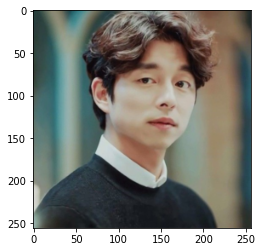

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 256

# 불러온 이미지가 Torch 객체로 변환될 수 있도록 하기
transform = []
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

img_path = "./gongyu.jpg"
image = Image.open(img_path)
# Torch의 첫 번째 차원은 배치(batch) 크기
image = transform(image).unsqueeze(0).to(device)

# 원본 이미지 출력
plt.imshow(solver.denorm(image.data.cpu()).squeeze(0).permute(1, 2, 0))

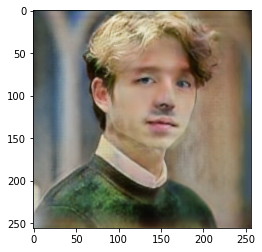

In [17]:
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
c_trg = [[0, 1, 0, 1, 1]]
c_trg = torch.FloatTensor(c_trg).to(device)
output = solver.G(image, c_trg)
plt.imshow(solver.denorm(output.data.cpu()).squeeze(0).permute(1, 2, 0))

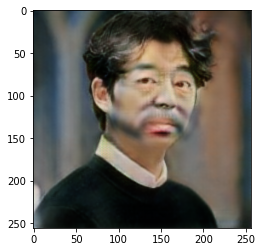

In [18]:
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
c_trg = [[1, 0, 0, 1, 0]]
c_trg = torch.FloatTensor(c_trg).to(device)
output = solver.G(image, c_trg)
plt.imshow(solver.denorm(output.data.cpu()).squeeze(0).permute(1, 2, 0))

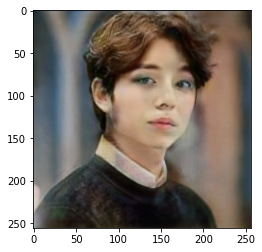

In [19]:
# [Black_Hair, Blond_Hair, Brown_Hair, Male, Young]
c_trg = [[0, 0, 1, 0, 1]]
c_trg = torch.FloatTensor(c_trg).to(device)
output = solver.G(image, c_trg)
plt.imshow(solver.denorm(output.data.cpu()).squeeze(0).permute(1, 2, 0))